# Flares in LSST Fields

*A few summary figures*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flare_prob
import toymodel
import LSSToy

In [2]:
# let's read in the Trilegal field, and see the columns

# l=45, b=-40, fov=3.5
# file = 'trilegal_models/output164538496014.dat'

# l=45, b=-10, fov=3.5
file = 'trilegal_models/output574523944248.dat'
df = pd.read_table(file, sep=r"\s*", engine='python')
df

,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,m2/m1,mbol,u,g,r,i,z,Mact
0,1,6.65,-0.29,0.02022,-2.791,3.383,4.013,11.9,0.037,0.00,23.648,32.703,29.267,27.621,25.274,23.676,0.020
1,1,6.65,-0.23,0.16054,-1.769,3.524,4.453,10.8,0.035,0.00,19.991,25.910,22.793,21.270,20.211,19.592,0.161
2,1,6.65,-0.19,0.10021,-1.898,3.499,4.279,11.3,0.036,0.00,20.814,27.356,24.049,22.461,21.177,20.437,0.100
3,1,6.65,-0.13,0.08522,-2.001,3.489,4.272,10.8,0.035,0.00,20.574,27.377,24.011,22.413,21.012,20.208,0.085
4,1,6.65,-0.13,0.02970,-2.574,3.417,4.100,11.6,0.037,0.80,22.208,30.346,27.174,25.575,23.469,22.102,0.030
5,1,6.65,-0.11,0.20927,-2.185,3.548,5.083,10.5,0.033,0.00,20.732,26.110,23.192,21.752,20.846,20.316,0.209
6,1,6.65,-0.11,0.01303,-3.473,3.275,4.073,10.7,0.034,0.87,23.663,40.502,33.240,29.720,27.206,25.102,0.013
7,1,6.65,-0.03,0.54233,-1.275,3.607,4.823,10.7,0.034,0.00,18.658,22.794,20.364,19.116,18.595,18.279,0.542
8,1,6.65,0.01,0.01924,-2.855,3.374,4.020,10.3,0.032,0.00,22.209,31.667,28.068,26.390,23.966,22.288,0.019
9,1,6.65,0.05,0.02663,-2.644,3.406,4.079,13.0,0.038,0.00,24.380,32.617,29.418,27.819,25.673,24.281,0.027


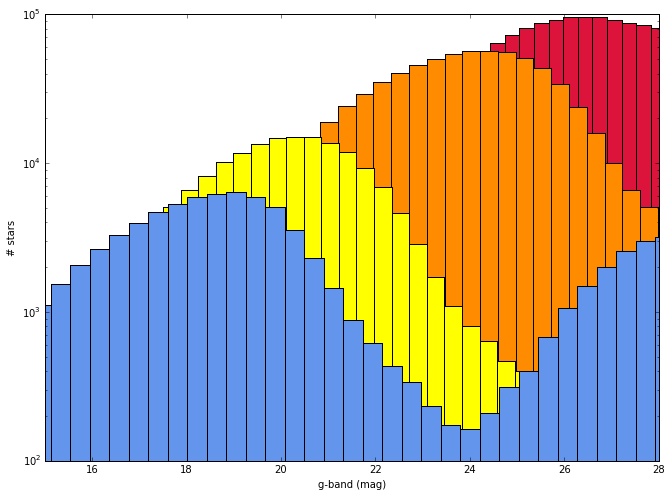

In [3]:
# make a histogram of # of stars versus Apparent Mag in each temperature bin (3k to 7k)
Teff_bins = np.log10(np.arange(3000,8000,1000))

fov = 3.5 # sq deg (size of Trilegal field)

clrs = ['crimson','darkorange','yellow','cornflowerblue']

plt.figure(figsize=(11,8))
for k in range(len(Teff_bins)-1):
    x = np.where((df['logg'] >= 4) & (df['logTe'] >= Teff_bins[k]) & (df['logTe'] < Teff_bins[k+1]))
    _ = plt.hist(df['g'].values[x], bins=50, color=clrs[k])
plt.yscale('log')
plt.xlim(15,28)
plt.ylim(1e2,1e5)
plt.xlabel('g-band (mag)')
plt.ylabel('# stars')

## Generate flares at different rates, test recovery % for LSST cadence

Only varying the $\alpha$ parameter, which controls the intercept in the Flare Frequency Distribution powerlaw. Thus we always use a fixed slope for the energy distribution, $\beta$.

In [4]:
s_time1, s_flux1 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=1.0)
s_time2, s_flux2 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=0.0)
s_time3, s_flux3 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=0.1)

In [5]:
s_time4, s_flux4 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=0.01)
s_time5, s_flux5 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=0.0001)
s_time6, s_flux6 = flare_prob.SuperLC(dur=0.2, repeat=50, mag=True, ffd_alpha=0.000001)

$\alpha$ = [1, 0, -1, ..., -2, -4, -6]

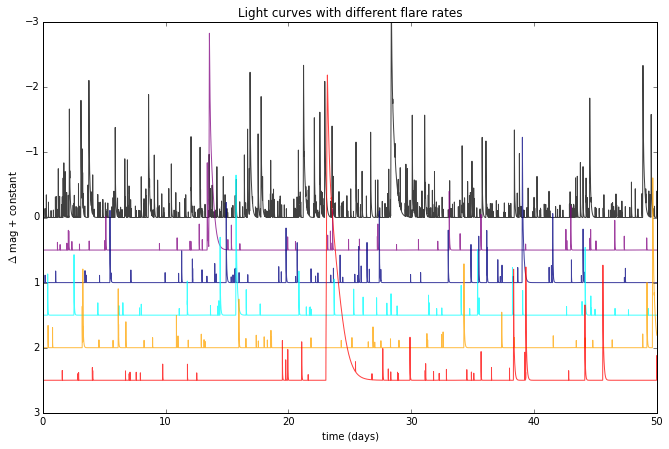

In [6]:
plt.figure(figsize=(11,7))
plt.plot(s_time1, s_flux1, alpha=0.75, c='black')
plt.plot(s_time2, s_flux2+0.5, alpha=0.75, c='purple')
plt.plot(s_time3, s_flux3+1, alpha=0.75, c='navy')
plt.plot(s_time4, s_flux4+1.5, alpha=0.75, c='cyan')
plt.plot(s_time5, s_flux5+2, alpha=0.75, c='orange')
plt.plot(s_time6, s_flux6+2.5, alpha=0.75, c='red')
plt.xlim(0,50)
plt.ylim((3,-3))
plt.xlabel('time (days)')
plt.ylabel('$\Delta$ mag + constant')
plt.title('Light curves with different flare rates')
plt.savefig('test.png', dpi=300)

In [7]:
dmag_limit = -0.1 # flare detection threshold

ntrials = 1000

npass1 = np.zeros(ntrials)
npass2 = np.zeros(ntrials)
npass3 = np.zeros(ntrials)
npass4 = np.zeros(ntrials)
npass5 = np.zeros(ntrials)
npass6 = np.zeros(ntrials)


for k in range(ntrials):
    t,f = toymodel.downsample(s_time1, s_flux1)
    ok = np.where((f <= dmag_limit))
    npass1[k] = len(ok[0])
    
    t,f = toymodel.downsample(s_time2, s_flux2)
    ok = np.where((f <= dmag_limit))
    npass2[k] = len(ok[0])
    
    t,f = toymodel.downsample(s_time3, s_flux3)
    ok = np.where((f <= dmag_limit))
    npass3[k] = len(ok[0])
    
    t,f = toymodel.downsample(s_time4, s_flux4)
    ok = np.where((f <= dmag_limit))
    npass4[k] = len(ok[0])
    
    t,f = toymodel.downsample(s_time5, s_flux5)
    ok = np.where((f <= dmag_limit))
    npass5[k] = len(ok[0])
    
    t,f = toymodel.downsample(s_time6, s_flux6)
    ok = np.where((f <= dmag_limit))
    npass6[k] = len(ok[0])

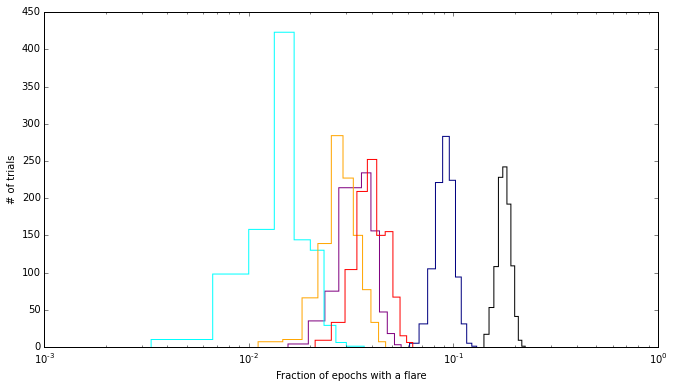

In [8]:
# change this to a cumulative distribution of delta mags, average the 1k trials

plt.figure(figsize=(11,6))
_ = plt.hist(npass1/900., histtype='step', color='black')
_ = plt.hist(npass2/900., histtype='step', color='purple')
_ = plt.hist(npass3/900., histtype='step', color='navy')
_ = plt.hist(npass4/900., histtype='step', color='cyan')
_ = plt.hist(npass5/900., histtype='step', color='orange')
_ = plt.hist(npass6/900., histtype='step', color='red')
plt.xlabel('Fraction of epochs with a flare')
plt.ylabel('# of trials')
plt.xscale('log')

## Now sample from the actual field!

In [9]:
Age_bins = np.log10([1e5, 1e9, 2e9, 15e9]) # edges of age bins

alpha_matrix = np.array([[1, 0, -2],   # 3k-4k
                    [0, -2, -4],  # 4k-5k
                    [-2, -4, -6], # 5k-6k
                    [-6, -9, -9]]) # 6k-7k

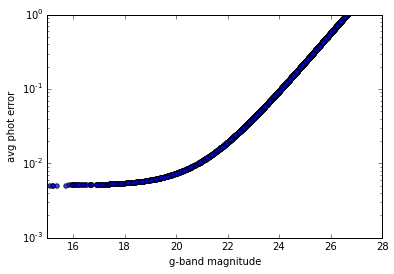

In [20]:
Nstars = 5000 # how many stars to randomly sample from logg>=4, Teff<7k

# find the stars to draw from
okstars = np.where((df['logg'] >= 4) & (df['logTe'] <= np.log10(7000.0)) & (df['logTe'] >= np.log10(3000.0)))

# pick random indexes to use from good stars
rr = np.array(np.floor((np.random.random(size=Nstars) * float(len(okstars[0])))), dtype=np.int)

teff = df['logTe'].values[okstars[0][rr]]
age = df['logAge'].values[okstars[0][rr]]

gmag = df['g'].values[okstars[0][rr]] # apparant g-band magnitude
gerr = LSSToy.photerror(gmag)

plt.scatter(gmag, gerr, alpha=0.75)
plt.ylim(1e-3,1)
plt.yscale('log')
plt.xlim(15,28)
plt.xlabel('g-band magnitude')
plt.ylabel('avg phot error')

In [21]:
# Count how many flares are returned for each star
Nflares = np.zeros(Nstars)

# loop over all Nstars and measure flare returns!
for k in range(Nstars):
    # which are bin?
    wage = min(np.where((Age_bins >= np.float(age[k])))[0]) - 1

    # which temp bin?
    wteff = min(np.where((Teff_bins >= np.float(teff[k])))[0]) - 1

    # pick the activity level based on that
    aa = alpha_matrix[wteff, wage]

    # pick the correct flare light curve
    if aa == 1:
        tt, ff = s_time1, s_flux1
    if aa == 0:
        tt, ff = s_time2, s_flux2
    if aa == -1:
        tt, ff = s_time3, s_flux3
    if aa == -2:
        tt, ff = s_time4, s_flux4
    if aa == -4:
        tt, ff = s_time5, s_flux5
    if aa == -6:
        tt, ff = s_time6, s_flux6
    if aa < -6: # no flares
        tt, ff = s_time6, s_flux6 * 0.0
    
    # down-sample to LSST cadence
    t,f = toymodel.downsample(tt, ff)
    
    # find where LSST data >= Flare threshold (+ phot errors!)
    ok = np.where((f <= (dmag_limit - gerr[k])))
    
    Nflares[k] = len(ok[0])

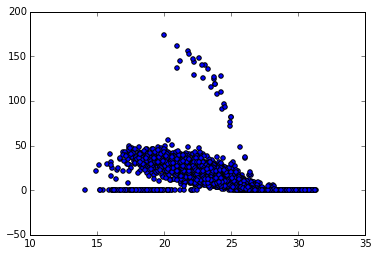

In [23]:
plt.scatter(gmag, Nflares)